In [12]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

import parallelproj  
import array_api_compat.numpy as xp
from scipy.ndimage import gaussian_filter

import odl

dev = "cpu"


#### Creating the 2D ellipses

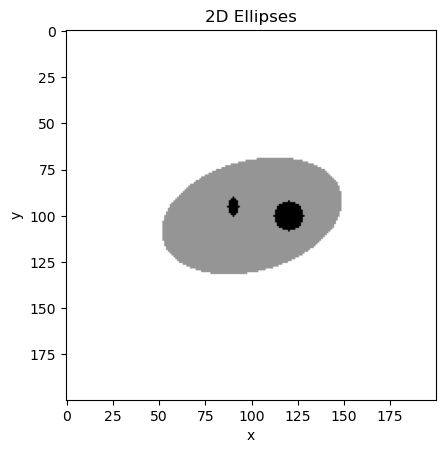

In [2]:
# Creating 2D ellipses
def create_2d_ellipsoid(image_shape, center, axes, angle=0, value=1.0):
    """
    Create a 2D ellipsoid in the image.

    Parameters:
    - image_shape: Tuple (height, width) for the 2D image.
    - center: Tuple (cy, cx) - center of the ellipsoid.
    - axes: Tuple (a, b) - semi-axes lengths along the y and x axes.
    - angle: Rotation angle of the ellipsoid in degrees (default is 0).
    - value: The value to assign inside the ellipsoid (default is 1.0).

    Returns:
    - image: The modified 2D image with the ellipsoid placed in it.
    """
    # Create an empty 2D image
    image = np.zeros(image_shape, dtype=np.float32)
    cy, cx = center
    a, b = axes
    angle_rad = np.radians(angle)  

    # Create coordinate grid
    y, x = np.meshgrid(
        np.arange(image_shape[0]),
        np.arange(image_shape[1]),
        indexing="ij"
    )

    # Translate grid to the center of the ellipsoid
    y_shifted, x_shifted = y - cy, x - cx

    # Apply rotation
    y_rot = x_shifted * np.sin(angle_rad) + y_shifted * np.cos(angle_rad)
    x_rot = x_shifted * np.cos(angle_rad) - y_shifted * np.sin(angle_rad)

    # Ellipsoid equation: (y_rot/a)^2 + (x_rot/b)^2 <= 1
    mask = (y_rot / a) ** 2 + (x_rot / b) ** 2 <= 1
    image[mask] = value

    return image

# Define image dimensions
image_shape = (200, 200) 

ellipsoid_1 = create_2d_ellipsoid(image_shape, center=(100, 100), axes=(30, 50), angle=15, value=0.5)
ellipsoid_2 = create_2d_ellipsoid(image_shape, center=(100, 120), axes=(8, 8), angle=0, value=7.0)
ellipsoid_3 = create_2d_ellipsoid(image_shape, center=(95, 90), axes=(5, 3), angle=0, value=1.0)

# Combine multiple ellipsoids and clip values to [0, 1]
image = np.clip(ellipsoid_1 + ellipsoid_2 + ellipsoid_3, 0, 1.0)

# Visualize the ellipsoids
plt.imshow(image, cmap="Greys", origin="upper")
plt.title("2D Ellipses")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


#### Setting up the sampling geometry

In [3]:
# Total counts
total_counts = 1e7
# Maximum angle of the sinogram projections
max_angle= xp.pi

# Angular undersampling factor
undersamp_factor = 3

# Number of detector bins
detector_bins = 200

# Total number of angles
total_angles = (int(0.5 * detector_bins * xp.pi * (max_angle / xp.pi)) + 1) // undersamp_factor

r = xp.linspace(-30, 30, detector_bins, device=dev, dtype=xp.float32)
theta = xp.linspace(0, max_angle, total_angles, endpoint=False, device=dev, dtype=xp.float32)

#### Creating the projector

In [4]:
# Create the ParallelViewProjector2D
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins),r,-theta,2 * float(np.max(r)),(float(np.min(r)), float(np.min(r))),(float(r[1] - r[0]), float(r[1] - r[0])),
)

# Apply forward projection
image_fwd = proj(image)


#### Simulating emission 

In [5]:
# Adding attenuation 
mu = 0.096 # linear attenuation coefficient of water in 511keV
image_fwd_att = xp.exp(-mu * proj(ellipsoid_1)) # exponantial decay

emission_image_fwd = image_fwd_att * image_fwd

# Background contamination is added to simulate scatter or random events
contamination = xp.full(image_fwd.shape, 0.1 * xp.mean(image_fwd_att * image_fwd), device=dev)

# Resolution factor for the Gaussion filter
res_factor = 1.5 # 0.5-1 --> higher resolution
# Simulate the finite detector resolution/blurring
for i in range(total_angles):
    emission_image_fwd[:, i] = xp.asarray(gaussian_filter(parallelproj.to_numpy_array(emission_image_fwd[:, i]), res_factor,),device=dev,)

emission_image_fwd = emission_image_fwd + contamination


# Scaled to ensure the total number of counts equals total_counts
count_fac = total_counts / float(xp.sum(emission_image_fwd))
emission_image_fwd *= count_fac
contamination *= count_fac

# Adding poisson noise 
emission_image_fwd = xp.asarray(np.random.poisson(parallelproj.to_numpy_array(emission_image_fwd)).astype(np.float32), device=dev,)

# Scatter/random events are removed, attenuation effects are corrected
image_fwd_corr = (emission_image_fwd - contamination) / image_fwd_att


Text(0, 0.5, '$\\theta$ (radians)')

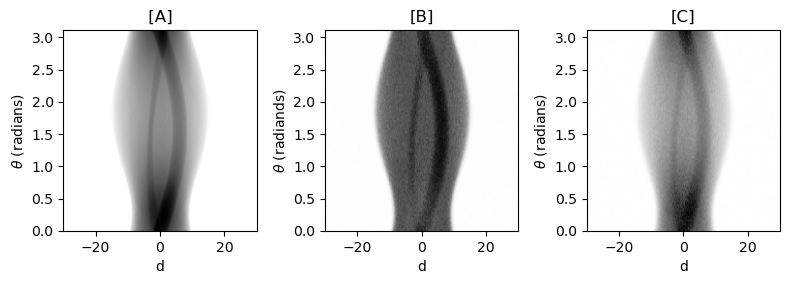

In [6]:
extent = [float(xp.min(r)), float(xp.max(r)), float(xp.min(theta)), float(xp.max(theta))]
fig, ax = plt.subplots(1, 3, figsize=(8, 4), tight_layout=True)
ax[0].imshow(parallelproj.to_numpy_array((image_fwd).T),cmap="Greys",aspect=20,extent=extent,origin="lower")
ax[0].set_title(" [A] ")#Sinogram of the Ellipse Imgae
ax[0].set_xlabel("d")
ax[0].set_ylabel(r"$\theta$ (radians)")

ax[1].imshow(parallelproj.to_numpy_array((emission_image_fwd).T),cmap="Greys",aspect=20,extent=extent,origin="lower")
ax[1].set_title("[B]") #Emission Sinogram
ax[1].set_xlabel("d")
ax[1].set_ylabel(r"$\theta$ (radiands)")

ax[2].imshow(parallelproj.to_numpy_array((image_fwd_corr).T),cmap="Greys",aspect=20,extent=extent,origin="lower")
ax[2].set_title("[C]")# Corrected Sinogram
ax[2].set_xlabel("d")
ax[2].set_ylabel(r"$\theta$ (radians)")

#### Creating and applying the ramp filter

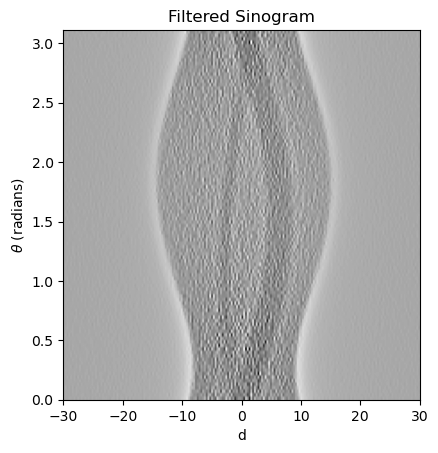

In [7]:
# Create the ramp filter
N = r.shape[0]
freq_index = xp.arange(N, device=dev, dtype=xp.float64) - N // 2  # Centerd 

filter = xp.zeros(N, device=dev, dtype=xp.float64)
# Set filter values for non-zero indices
filter[freq_index != 0] = -1 / (xp.pi**2 * freq_index[freq_index != 0] ** 2)
# Zero out values at even indices
filter[(freq_index % 2) == 0] = 0 
# Set the center value of the filter 
filter[freq_index == 0] = 0.25
 

filt_image_fwd = 1.0 * image_fwd_corr 
for i in range(total_angles):
    # Convolution operation between the projection and the ramp filter
     filt_image_fwd[:, i] = xp.asarray(np.convolve(parallelproj.to_numpy_array(filt_image_fwd[:, i]),filter,mode="same",),device=dev,)
     
plt.imshow(parallelproj.to_numpy_array(filt_image_fwd.T),cmap="Greys",aspect=20,extent=extent,origin="lower")
plt.title("Filtered Sinogram")
plt.xlabel("d")
plt.ylabel(r"$\theta$ (radians)")
plt.show()


Text(0, 0.5, 'y')

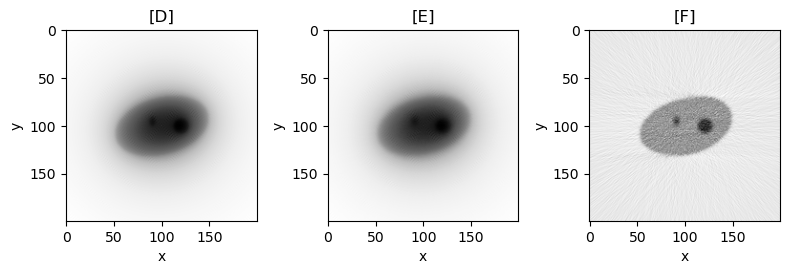

In [8]:
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins),r,-theta,2 * float(np.max(r)),(float(np.min(r)), float(np.min(r))),(float(r[1] - r[0]), float(r[1] - r[0])),
)
# Backproject the sinograms
image_fbp = proj.adjoint(filt_image_fwd)
image_bp = proj.adjoint(image_fwd_corr)

original_image_bp = proj.adjoint(image_fwd)

fig, ax = plt.subplots(1, 3, figsize=(8, 4), tight_layout=True)
ax[0].imshow(parallelproj.to_numpy_array(original_image_bp),cmap="Greys")
ax[0].set_title("[D]") # Back-projection of the Original Ellipse Sinogram
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].imshow(parallelproj.to_numpy_array(image_bp),cmap="Greys")
ax[1].set_title("[E]") # Back-projection of the Corrected Emission Sinogram
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

ax[2].imshow(parallelproj.to_numpy_array(image_fbp),cmap="Greys")
ax[2].set_title("[F]") # Back-projection of the Filteres Sinogram
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")


